# Lensing cross kSZ effect signal in Modified Gravity models

This notebook serves as a tutorial on how we compute the signal to noise ratio of the cross-correlation between the weak lensing convergence field and the kinetic Sunyaev-Zeldovich (kSZ) effect, in models beyond the scope of $\Lambda$CDM.

This cross-correlation is only non-zero due to the gravitomagnetic contribution to the weak-lensing convergence field, hence we regard this as a probe for the gravitomagnetic field B, i.e. the vector modes of the spacetime metric.

---

The relevant equations are:

\begin{equation}
C^{XY}_\ell=\frac{1}{2}\int{\rm d}\chi\chi^{-2}K_X(\chi)K_{Y}(\chi)P_{q_\perp}\left(k=\frac{\ell}{\chi},z(\chi)\right),
\end{equation}

where 
\begin{align}
    K_{\kappa_{\bf B}}(\chi) &= \frac{3}{2}H_0^2\Omega_ma^{-1}\int_0^{\chi}{\rm d}\chi'\frac{\chi'(\chi-\chi')}{\chi}\frac{{\rm d}\chi'}{{\rm d}z}p\left(z(\chi')\right),\\
    K_b(\chi) &= \frac{\sigma_{\rm T}\bar{n}_{e,0}}{c}a(\chi)^{-2}e^{-\tau},
\end{align}
are the kernels for the gravitomagnetic lensing convergence and kSZ effect, respectively.

Notice that the $C_\ell$ calculation is further simplified due to the simple choice of $p(z(\chi'))=\delta^{{\rm D}}(\chi'-\chi_s)$. Hence the lensing kernel becomes
\begin{align}
 K_{\kappa_{\bf B}}(\chi) &= \frac{3}{2}H_0^2\Omega_ma^{-1}\int_0^{\chi}{\rm d}\chi'\frac{\chi'(\chi-\chi')}{\chi}\frac{{\rm d}\chi'}{{\rm d}z}p\left(z(\chi')\right),\\
                          &= \frac{3}{2}H_0^2\Omega_ma^{-1}\frac{\chi_s(\chi-\chi_s)}{\chi}H^{-1}(\chi_s)
\end{align}

---

\begin{equation}
    C_{ij}^{XY}(\ell) = c\int_{z_\text{min}}^{z_\text{max}}dz\frac{W_i^X(z)W_j^Y(z)}{H(z)r^2(z)}P_{\delta\delta}(k_\ell,z)
\end{equation}

For compiling Pylians in a mac:

`set -x CC (brew --prefix llvm)/bin/clang

set -x CXX (brew --prefix llvm)/bin/clang++

set -x CPPFLAGS "-I"(brew --prefix llvm)"/include -I"(brew --prefix libomp)"/include"

set -x LDFLAGS "-L"(brew --prefix llvm)"/lib -L"(brew --prefix libomp)"/lib"
`


In [1]:
# Import some libraries
import numpy as np
import h5py
import os
from scipy.integrate import quad, simpson, odeint
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import brentq
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import scienceplots

from classy import Class

import plotting_library as PL
from pylab import *
import MAS_library as MASL
import Pk_library as PKL

plt.style.use(['science', 'no-latex'])
plt.rcParams.update({
    # Figure
    'figure.figsize': (6.8, 4.2),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,

    # Lines and markers
    'lines.linewidth': 1.5,
    'lines.markersize': 5,

    # Font
    'font.size': 9,
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,

    # Axes
    'axes.linewidth': 1.0,
    'axes.grid': False,
    'grid.alpha': 0.3,

    # Ticks
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 4,
    'ytick.major.size': 4,

    # Legend
    'legend.frameon': False,

    # Text rendering (LaTeX)
    'text.usetex': False,               # Optional: needs LaTeX installed
    'text.latex.preamble': r'\usepackage{amsmath,amssymb}',  # Optional
})

In [2]:
# Read parameters used in simulation

def read_params_file(path):
    """
    Read a simple 'key value' parameters file (like Gadget .param) and return dict.
    Lines starting with # or empty lines are ignored.
    """
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"{path} not found")
    d = {}
    with p.open() as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = line.split()
            if len(parts) < 2:
                continue
            key = parts[0]
            # join remainder in case value contains spaces (not expected but safe)
            val = " ".join(parts[1:])
            # try to cast to float or int if possible, else keep string
            try:
                if '.' in val or 'e' in val.lower():
                    d[key] = float(val)
                else:
                    d[key] = int(val)
            except Exception:
                d[key] = val
    return d

def build_cosmo_params_from_file(path, extra_defaults=None):
    """
    Read simulation params and return a cosmo_params dict with derived values.
    extra_defaults: optional dict to override/add defaults (e.g. SigmaT, Yp).
    """
    sim = read_params_file(path)

    # map keys (handle common names)
    # fallbacks if keys don't exist in the file
    Omega_m = float(sim.get("Omega0", sim.get("Omega0", sim.get("Omega0", 0.31315))))
    Omega_L = float(sim.get("OmegaLambda", 1.0 - Omega_m))
    Omega_b = float(sim.get("OmegaBaryon", sim.get("OmegaB", 0.049199)))
    # HubbleParam in many sim files is h (dimensionless). We'll use it if present.
    h_sim = sim.get("HubbleParam", sim.get("h", None))
    if h_sim is None:
        # no h given, try to compute from guessed H0
        H0_guess = sim.get("H0", None)
        if H0_guess is not None:
            h = float(H0_guess) / 100.0
        else:
            h = 0.6737
    else:
        h = float(h_sim)

    H0 = 100.0 * h

    BoxSize = float(sim.get("BoxSize", np.nan))  # usually in (comoving) Mpc/h; check your code convention

    # Unit conversions (optional but useful)
    UnitLength_in_cm = float(sim.get("UnitLength_in_cm", 3.08568e24))
    UnitMass_in_g = float(sim.get("UnitMass_in_g", 1.989e+43))
    UnitVelocity_in_cm_per_s = float(sim.get("UnitVelocity_in_cm_per_s", 100000.0))

    # Physical constants / defaults (you can override via extra_defaults)
    defaults = {
        "c": 3.0e5,          # speed of light km/s
        "m_ele": 9.10938356e-31, # kg
        "m_H": 1.6726219e-27,  # kg
        "m_He": 6.6464764e-27, # kg (approx)
        "SigmaT": 6.6524587321e-29, # m^2
        "Ombh2": Omega_b * h**2,
        "xe": 1.0,
        "Yp": 0.25,
    }
    if extra_defaults:
        defaults.update(extra_defaults)

    # derived
    params = {}
    params.update(defaults)
    params["Omega_m"] = Omega_m
    params["Omega_Lambda"] = Omega_L
    params["Omega_b"] = Omega_b
    params["h"] = h
    params["H0"] = H0
    params["BoxSize"] = BoxSize
    params["UnitLength_in_cm"] = UnitLength_in_cm
    params["UnitMass_in_g"] = UnitMass_in_g
    params["UnitVelocity_in_cm_per_s"] = UnitVelocity_in_cm_per_s

    # critical density (kg/m^3). Note: original number used in your notebook was 1.88e-26 * h**2
    params["rho_c"] = 1.88e-26 * h**2

    # tau_H and kSZ prefactor example (same formula you used previously)
    params["tau_H"] = 0.07 * (1.0 - params["Yp"]) * params["Ombh2"] / params["h"]
    params["kSZ_bfac"] = params["tau_H"] * params["xe"]

    # keep original sim dict in case you need other keys
    params["simfile_raw"] = sim

    return params

In [3]:
parameters_sim = build_cosmo_params_from_file("parameters-usedvalues")

parameters_sim['w_de'] = -1

## Computing the power spectrum of the divergence-free component of a vector.

In general, for a rotational vector $u^i$, the power spectrum is defined via:

\begin{equation}
    \langle u^i(\vec{k})u^j(\vec{k'})\rangle = \delta^{(3)}(\vec{k}-\vec{k'}) (2\pi)^3 \frac{1}{2} \left(\delta^{ij}-\frac{k^ik^j}{k^2}\right)P_u(k)
\end{equation}

In particular, we are interested in the power spectrum of the curl of the momentum density field $\vec{q}\equiv(1+\delta)\vec{v}$, with $\vec{v}$ the velocity field. Let's call this quantity a vorticity density $\vec{\omega}=\nabla\times\vec{q}=\nabla\times[(1+\delta)\vec{v}]$ 

Some useful relations:
\begin{equation}
    k^4 P_B \sim P_{q\perp}\sim k^{-2}P_\omega.
\end{equation}

Recall that:
\begin{equation}
    \Delta(k) = \frac{k^3P(k)}{2\pi^2}
\end{equation}
We aim to compute $P_\omega$ and then transform it into any useful power spectrum that we want.

---

The basic steps are:
1. Deposit particles in a grid, to have them as a field.
2. Visualize the fields, its always nice to do.
3. Use Pylians to compute the respective power spectrum.
4. Interpolate the power spectra obtained, so we can use it in the next section.

### Building the fields

In [4]:
# # Load data and save it as .npy files

# nparts = 0
# for i in range(8):
#     with h5py.File(f"snapdir_000/snap_000.{i}.hdf5", "r") as f:
#         nparts += f['PartType1']['Coordinates'].shape[0]

# print("Total DM particles:", nparts)

# # Allocate big arrays up front
# pos = np.empty((nparts, 3), dtype=np.float32)
# vel = np.empty((nparts, 3), dtype=np.float32)

# # Second pass: fill them
# offset = 0
# for i in range(8):
#     with h5py.File(f"snapdir_000/snap_000.{i}.hdf5", "r") as f:
#         coords = f['PartType1']['Coordinates'][:]
#         vels = f['PartType1']['Velocities'][:]

#         n = coords.shape[0]
#         pos[offset:offset+n] = coords
#         vel[offset:offset+n] = vels
#         offset += n

# print("Final shapes:", pos.shape, vel.shape)

# # Optional: save to disk
# np.save("PartType1_Coordinates.npy", pos)
# np.save("PartType1_Velocities.npy", vel)

In [5]:
# def read_snap(N,snap,path):
#   """
#   Function given by Cristian's collaborator.
#   """
#   Lbox = 500. #L=1500 Mpc/h or 500 Mpc/h
#   pos_c = [None]*N

#   path = path+'/snapdir_%03d/'%snap

#   print("Data read from %s"%path)
  
#   infile = h5py.File(path+"snap_%03d.0.hdf5"%snap,"r")
#   print ('Redshift z=%1.2f'%infile["Header"].attrs["Redshift"])
  
#   for i in range(N):
#     f = h5py.File(path+"snap_%03d.%i.hdf5"%(snap,i),"r")
#     pos_c[i] = f["PartType1/IntegerCoordinates"][...]
#     f.close()

#   pos_c = np.concatenate(pos_c)
#   return pos_c/pow(2.0,32)*Lbox

# path_GR = os.getcwd()
# path1_a = path_GR
# posa_GR = read_snap(8,0,path1_a)

# np.save('Coordinates.npy', posa_GR)

In [6]:
# # Build the overdensity field (delta) using Pylians

# # density field parameters
# Ngrid    = 1024     #the 3D field will have grid x grid x grid voxels
# BoxSize = 500.0     #Mpc/h ; size of box
# MAS     = 'CIC'     #mass-assigment scheme
# verbose = True      #print information on progress

# # particle positions in 3D
# pos = np.load('outputs/Coordinates.npy').astype(np.float32)

# # define 3D density field
# delta_3d = np.zeros((Ngrid,Ngrid,Ngrid), dtype=np.float32)

# # construct 3D density field
# MASL.MA(pos, delta_3d, BoxSize, MAS, verbose=verbose)

# # at this point, delta contains the effective number of particles in each voxel
# # now compute overdensity and density constrast
# # save the density field as rho.npy
# np.save('outputs/rho.npy', delta_3d)
# delta_3d /= np.mean(delta_3d, dtype=np.float64)
# delta_3d -= 1.0

# np.save('outputs/delta_3d.npy', delta_3d)

In [7]:
# # Build momentum density field using Pylians

# BoxSize = 500.0
# Ngrid   = 1024
# MAS     = 'CIC'

# pos = np.load('outputs/Coordinates.npy').astype(np.float32)
# vel = np.load('outputs/Velocities.npy').astype(np.float32)

# rho = np.load('outputs/rho.npy')      
# print('data loaded')

# # qx = np.zeros_like(rho)
# # qy = np.zeros_like(rho)
# qz = np.zeros_like(rho)

# print('Computing vel fields...')

# MASL.MA(pos, qx, BoxSize, MAS, vel[:,0].astype(np.float32), True)
# qx /= np.mean(rho)
# np.save('outputs/Momentum_field_x.npy', qx)
# print('x saved')

# MASL.MA(pos, qy, BoxSize, MAS, vel[:,1].astype(np.float32), True)
# qy /= np.mean(rho)
# np.save('outputs/Momentum_field_y.npy', qy)
# print('y saved')

# MASL.MA(pos, qz, BoxSize, MAS, vel[:,2].astype(np.float32), True)
# qz /= np.mean(rho)
# np.save('outputs/Momentum_field_z.npy', qz)
# print('z saved')

In [10]:
# Load previously computed fields
delta_3d = np.load('outputs/delta_3d.npy')
qx_field = np.load('outputs/Momentum_field_x.npy')
qy_field = np.load('outputs/Momentum_field_y.npy')
qz_field = np.load('outputs/Momentum_field_z.npy')

### Visualizing the fields

In [ ]:
def plot_field(field, field_name, slice_idx=None, linthresh=1.0, cmap='hot', vmin=None, vmax=None):
    """
    Plot a 2D slice of a 3D cosmological field (density, overdensity, or momentum).

    Parameters
    ----------
    field : ndarray
        2D or 3D array to plot.
    field_name : str
        Name of the field: 'delta', 'density', 'q_x', 'q_y', 'q_z'
    slice_idx : int, optional
        Slice index along the 3rd axis if field is 3D. Default: middle slice.
    linthresh : float
        Linear threshold for SymLogNorm (delta and momentum fields).
    cmap : str
        Colormap to use.
    vmin, vmax : float, optional
        Color limits. If None, they will be determined automatically.
    """

    # Take middle slice if 3D
    if field.ndim == 3:
        if slice_idx is None:
            slice_idx = field.shape[2] // 2
        data = field[:, :, slice_idx].copy()
    else:
        data = field.copy()

    # Determine norm and label
    if field_name == 'density':
        data = data + 1
        label = r"$\rho/\bar{\rho}$"

    elif field_name == 'delta':
        label = r"$\delta$"

    elif field_name in ['q_x', 'q_y', 'q_z']:
        label = rf"${field_name}$"

    else:
        raise ValueError("field_name must be 'delta', 'density', 'q_x', 'q_y', or 'q_z'")

    # Plot
    norm = SymLogNorm(linthresh=linthresh,
                  vmin=vmin if vmin is not None else np.min(data),
                  vmax=vmax if vmax is not None else np.max(data))
    
    fig, ax = plt.subplots()
    cax = ax.imshow(data, cmap=cmap, norm=norm)
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label(label, fontsize=14)
    ax.set_title(f"{field_name} field slice {slice_idx}")
    plt.show()

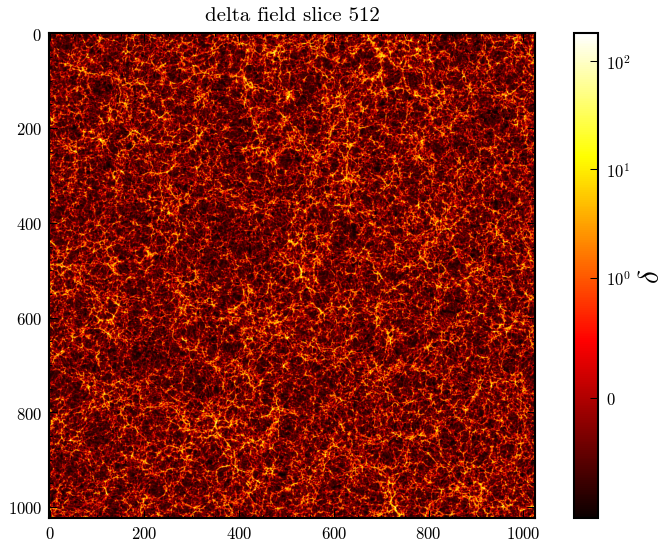

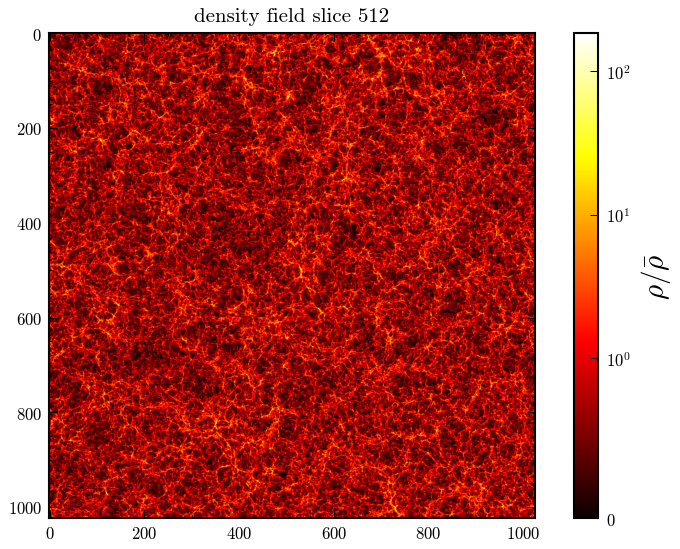

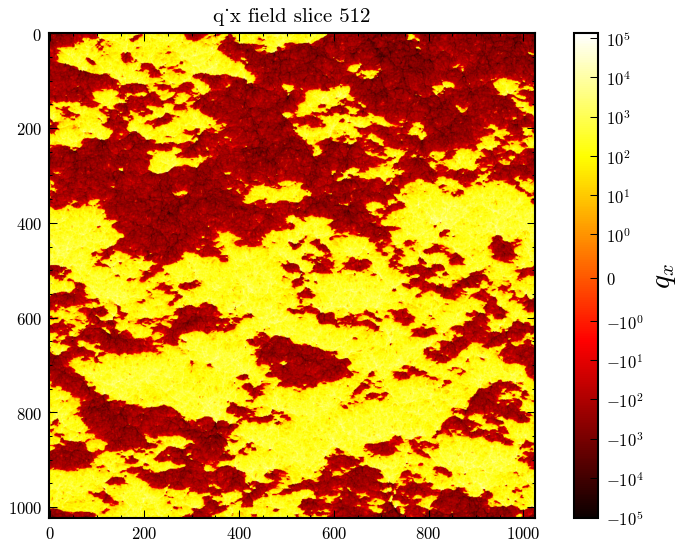

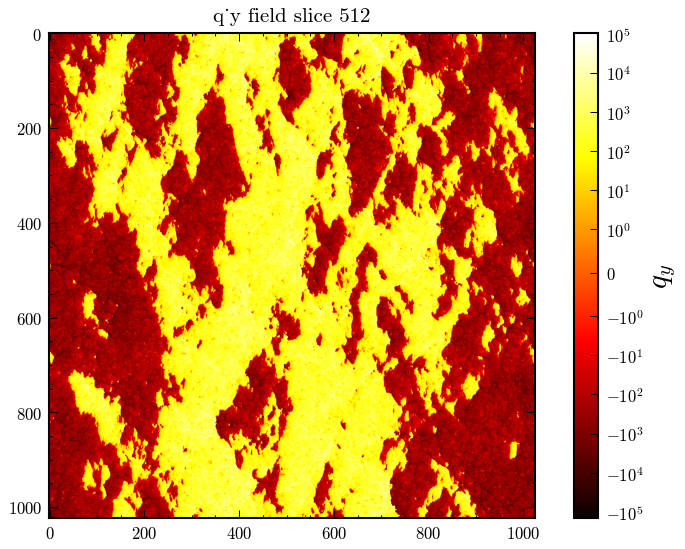

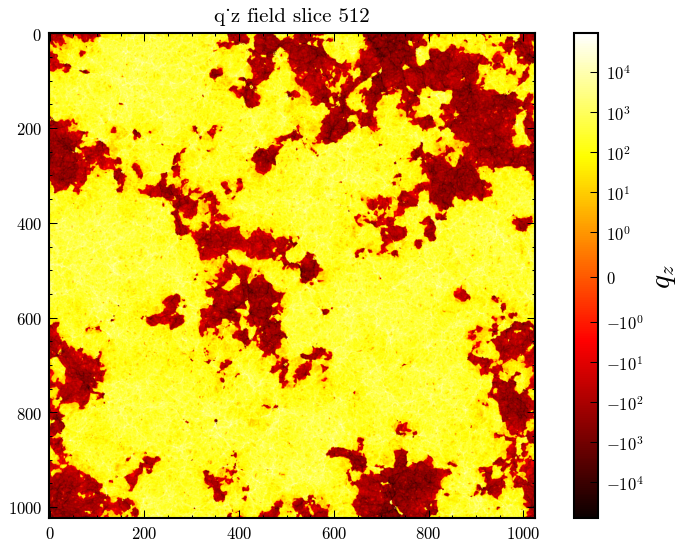

In [ ]:
plot_field(delta_3d, 'delta')
plot_field(delta_3d, 'density')
plot_field(qx_field, 'q_x')
plot_field(qy_field, 'q_y')
plot_field(qz_field, 'q_z')

### Computing the matter power spectrum

In [ ]:
# # compute matter power spectrum using Pylians

# Pk = PKL.Pk(delta_3d, 500, 0, 'CIC', 1, True)

# # Pk is a python class containing the 1D, 2D and 3D power spectra, that can be retrieved as

# # # 1D P(k)
# # k1D      = Pk.k1D
# # Pk1D     = Pk.Pk1D
# # Nmodes1D = Pk.Nmodes1D

# # # 2D P(k)
# # kpar     = Pk.kpar
# # kper     = Pk.kper
# # Pk2D     = Pk.Pk2D
# # Nmodes2D = Pk.Nmodes2D

# # 3D P(k)
# k       = Pk.k3D
# Pk0     = Pk.Pk[:,0] #monopole
# # Pk2     = Pk.Pk[:,1] #quadrupole
# # Pk4     = Pk.Pk[:,2] #hexadecapole
# # Pkphase = Pk.Pkphase #power spectrum of the phases
# # Nmodes  = Pk.Nmodes3D

# np.save('outputs/k_m.npy', k)
# np.save('outputs/Pk_m.npy', Pk0)

In [4]:
# Load matter power spectrum previously computed with Pylians
k_m = np.load('outputs/k_m.npy')
Pk_m = np.load('outputs/Pk_m.npy')

In [5]:
CLASS = {}

# --- Cosmology parameters ---
params_base = {
    'output': 'mPk, lCl, tCl',
    'P_k_max_h/Mpc': 20.0,
    'h': parameters_sim['h'],
    'Omega_cdm': parameters_sim['Omega_m'] - parameters_sim['Omega_b'],
    'Omega_b': parameters_sim['Omega_b'],
    'A_s': 2.1e-9,
    'n_s': 0.965,
    'tau_reio': 0.06,
    'modes': 's',
    'lensing': 'yes',
    'l_max_scalars': 3000,
    'l_switch_limber': 100
}

# --- Constant z run (e.g. z=3 only) ---
params_const = params_base.copy()
params_const.update({'z_pk': '3.0'})

CLASS['const_z'] = Class()
CLASS['const_z'].set(params_const)
CLASS['const_z'].compute()

# --- Variable z run ---
params_var = params_base.copy()
params_var.update({'z_pk': '0, 0.1 ,0.5 ,1., 2., 3.'})

CLASS['var_z'] = Class()
CLASS['var_z'].set(params_var)
CLASS['var_z'].compute()


# --- Define k grid (in h/Mpc) ---
k_vals = np.logspace(-3, 1, 1000)

# --- Get P(k,z) at several z=3 ---
Pk_m_class_const_z = np.array([CLASS['const_z'].pk(k, 3) for k in k_vals])

# --- Get P(k,z) at several z ---
z_list = [0, 0.1, 0.5, 1., 2., 3.]

Pk_m_class_varz = np.array([
    [CLASS['var_z'].pk(k, z) for k in k_vals] 
    for z in z_list
])

Pk_m_class_varz_4interp = Pk_m_class_varz.T   # shape = (len(k_vals), len(z_list))



# --- Get lensing Cl from CLASS ---
cl = CLASS['var_z'].lensed_cl(3000)  # lensed Cls
ells = cl['ell']
Cl_pp = cl['pp']  # lensing potential power spectrum
Cl_kk = 0.25 * ells**2 * (ells + 1)**2 * Cl_pp  # convergence spectrum

In [6]:
### Interpolating power spectra:

from scipy.interpolate import RegularGridInterpolator, interp1d
z_list = [0, 0.1, 0.5, 1., 2., 3.]
k_vals = np.logspace(-3, 1, 1000)

Pk_m_class_constz_interp = interp1d(k_vals, Pk_m_class_const_z, kind='cubic')

# Build interpolator: axes are (z, k)
Pk_m_class_varz_interp = RegularGridInterpolator(
    (k_vals, z_list),   # grid coordinates
    Pk_m_class_varz_4interp,            # array with shape (len(z_list), len(k_vals))
    method='cubic',    # or "cubic" if you prefer smoother
    bounds_error=False,
    fill_value=None
)

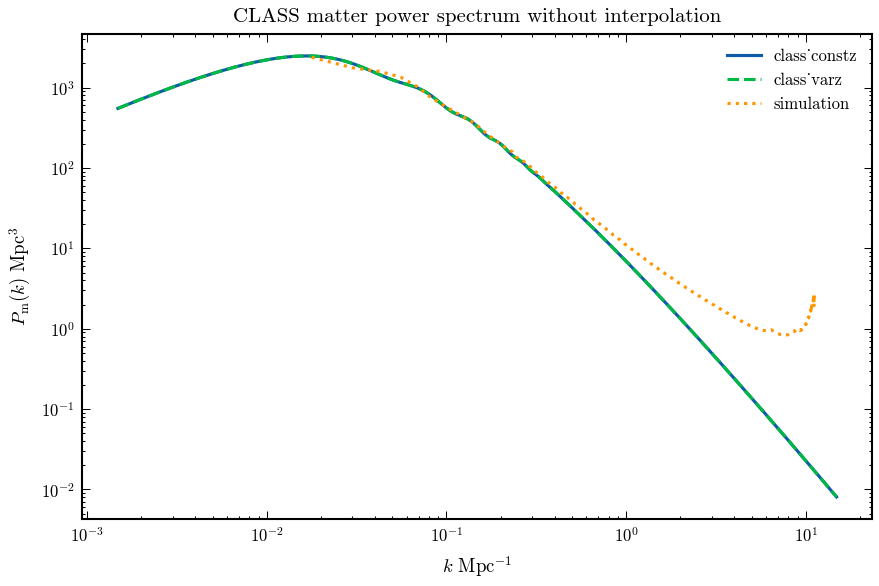

In [7]:
fig, ax = plt.subplots()

h_constz = CLASS['const_z'].h()
h_varz = CLASS['var_z'].h()

ax.loglog(k_vals/h_constz, Pk_m_class_const_z*(h_constz**3), label='class_constz')
ax.loglog(k_vals/h_varz, Pk_m_class_varz[-1]*(h_varz**3), '--', label='class_varz')
ax.loglog(k_m, Pk_m, ':', label='simulation')

ax.set_ylabel(r'$P_\text{m}(k)$ Mpc$^3$')
ax.set_xlabel(r'$k$ Mpc$^{-1}$')
ax.set_title('CLASS matter power spectrum without interpolation')
ax.legend()

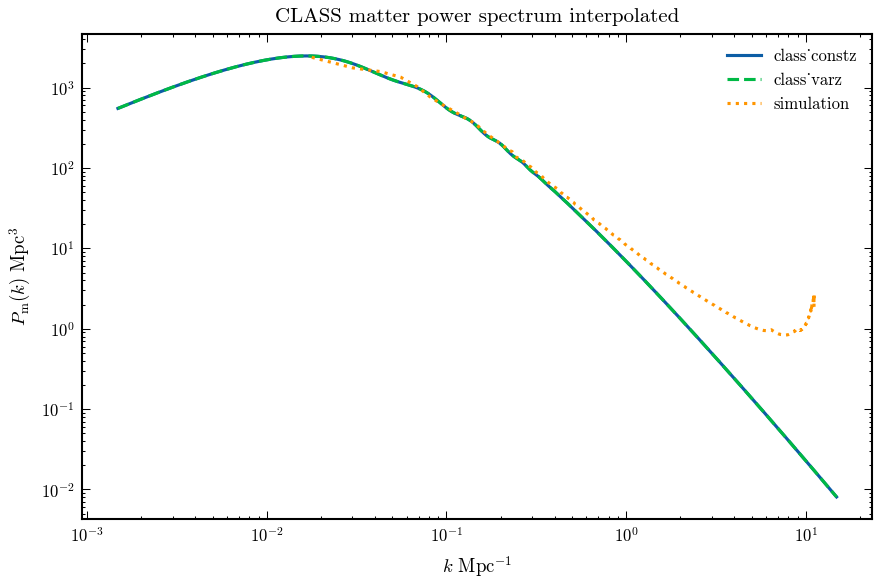

In [8]:
fig, ax = plt.subplots()
h_constz = CLASS['const_z'].h()
h_varz = CLASS['var_z'].h()

ax.loglog(k_vals/h_constz, Pk_m_class_constz_interp(k_vals)*h_constz**3, label='class_constz')
ax.loglog(k_vals/h_varz, Pk_m_class_varz_interp((k_vals, 3))*h_varz**3, '--', label='class_varz')
ax.loglog(k_m, Pk_m, ':', label='simulation')

# ax.loglog(k_vals, Pk_m_class, ':', label='class')

# ax.loglog(k_m, Pk_m_class, ':', label='class')
ax.set_ylabel(r'$P_\text{m}(k)$ Mpc$^3$')
ax.set_xlabel(r'$k$ Mpc$^{-1}$')
ax.set_title('CLASS matter power spectrum interpolated')
ax.legend()

### Computing the power spectrum of the divergence-free component of a vector.


In [11]:
# # Compute curl power spectrum using Pylians

k, Pk_curl, Nmodes = PKL.Pk_curl(qx_field, qy_field, qz_field, 1024, MAS='CIC', threads=1, cross_terms=True)

Computing power spectra of the fields...
Time compute modulus = 64.69
Time taken = 215.91 seconds


In [ ]:
# np.save('outputs/k_curl.npy', k)
# np.save('outputs/Pk_curl.npy', Pk_curl)
# np.save('outputs/Nmodes_curl.npy', Nmodes)

In [12]:
# Load power spectrum previously computed 

k_q = np.load('outputs/k_curl.npy')
Pk_omega = np.load('outputs/Pk_curl.npy')
Nmodes_omega = np.load('outputs/Nmodes_curl.npy')

Text(0, 0.5, '$\\Delta_\\text{B}(k)$')

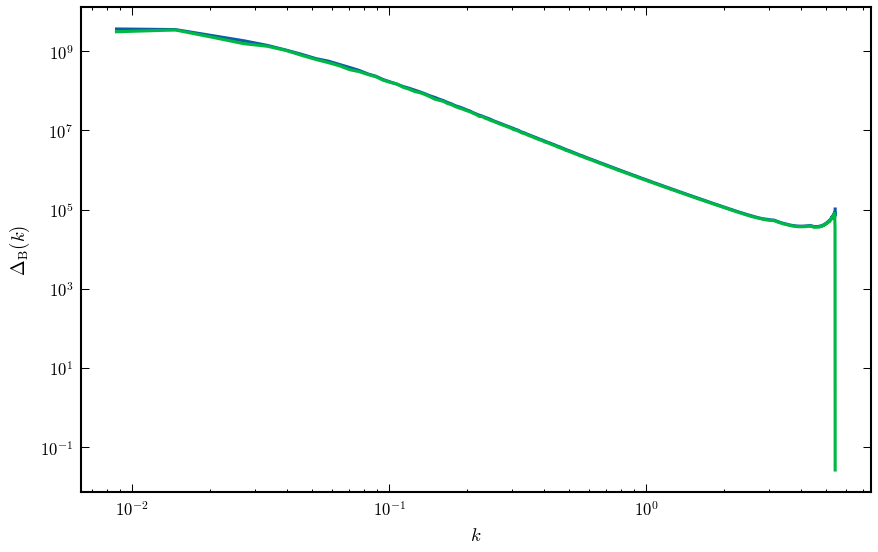

In [14]:
fig, ax = plt.subplots()

ax.loglog(k_q, Pk_omega/(k_q**3)/(2*np.pi**2))
ax.loglog(k, Pk_curl/(k**3)/(2*np.pi**2))
ax.set_xlabel('$k$')
ax.set_ylabel(r'$\Delta_\text{B}(k)$')

In [ ]:
k_q.shape

(886,)

Text(0, 0.5, '$\\Delta_\\text{B}(k)$')

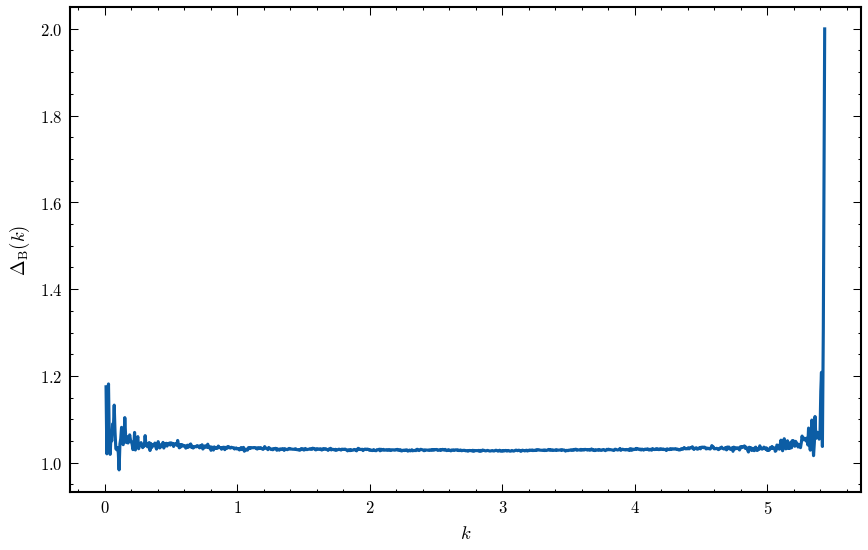

In [26]:
idx = 1

fig, ax = plt.subplots()

ax.plot(k_q[:-idx], Pk_omega[:-idx]/Pk_curl[:-idx])
ax.set_xlabel('$k$')
ax.set_ylabel(r'$\Delta_\text{B}(k)$')

In [28]:
def test_uniform_field():
    N = 32
    BoxSize = 1.0
    qx = np.ones((N,N,N), dtype=np.float32)
    qy = np.zeros((N,N,N), dtype=np.float32)
    qz = np.zeros((N,N,N), dtype=np.float32)

    k, Pk, Nmodes, (omegax, omegay, omegaz) = PKL.Pk_curl(qx,qy,qz,BoxSize,return_curl=True)

    # Analytical expectation: curl = 0 everywhere
    rms = np.sqrt(np.mean(omegax**2 + omegay**2 + omegaz**2))
    print("Uniform field test: RMS curl =", rms)
    print("Power spectrum sum =", Pk.sum())
    assert np.allclose(rms, 0.0, atol=1e-6)
    assert np.allclose(Pk, 0.0, atol=1e-6)

test_uniform_field()

Computing power spectra of the fields...
Time compute modulus = 0.00
Time taken = 0.01 seconds
Uniform field test: RMS curl = 0.0
Power spectrum sum = 0.0


In [29]:
def test_solid_rotation():
    N = 32
    BoxSize = 1.0
    dx = BoxSize / N
    grid = np.arange(N) * dx
    X, Y, Z = np.meshgrid(grid, grid, grid, indexing="ij")

    qx = -Y.astype(np.float32)
    qy =  X.astype(np.float32)
    qz = np.zeros_like(qx, dtype=np.float32)

    k, Pk, Nmodes, (omegax, omegay, omegaz) = PKL.Pk_curl(qx,qy,qz,BoxSize,return_curl=True)

    # Analytical expectation: curl = (0,0,2)
    curl_rms = np.sqrt(np.mean(omegax**2 + omegay**2 + (omegaz-2.0)**2))
    print("Solid rotation test: deviation from (0,0,2) =", curl_rms)
    print("Mean omega_z =", omegaz.mean(), "Expected 2.0")

test_solid_rotation()

Computing power spectra of the fields...
Time compute modulus = 0.00
Time taken = 0.00 seconds
Solid rotation test: deviation from (0,0,2) = 2.277202
Mean omega_z = -1.8626451e-09 Expected 2.0


In [30]:
def test_plane_wave():
    N = 32
    BoxSize = 1.0
    dx = BoxSize / N
    grid = np.arange(N) * dx
    X, Y, Z = np.meshgrid(grid, grid, grid, indexing="ij")

    k0 = 2*np.pi / BoxSize  # fundamental mode along z
    qx = np.sin(k0*Z).astype(np.float32)
    qy = np.zeros_like(qx)
    qz = np.zeros_like(qx)

    k, Pk, Nmodes, (omegax, omegay, omegaz) = PKL.Pk_curl(qx,qy,qz,BoxSize,return_curl=True)

    # Analytical expectation: curl = (0, -k0 cos(k0 z), 0)
    curl_y_analytic = -k0*np.cos(k0*Z)
    diff = np.sqrt(np.mean((omegay - curl_y_analytic)**2))
    norm_ratio = np.mean(omegay / curl_y_analytic)

    print("Plane wave test: RMS error =", diff)
    print("Mean ratio numerical/analytic =", norm_ratio)

test_plane_wave()

Computing power spectra of the fields...
Time compute modulus = 0.00
Time taken = 0.00 seconds
Plane wave test: RMS error = 5.152265896422966
Mean ratio numerical/analytic = -0.13366174052694893


### Interpolating power spectra from simulations

In [14]:
Pk_matter_int = interp1d(k_m, Pk_m, kind='quadratic')
Pk_omega_int = interp1d(k_q, Pk_omega, kind='quadratic')

## Computing $C_\ell$ for the cross correlation

In [15]:
##############################################################
# Some useful functions
##############################################################
def a_of_z(z):
    """
    Scale factor as a function of redshift.
    """
    return 1/(1+z)


def z_of_a(a):
    """
    Redshift as a function of the scale factor.
    """
    return 1/a - 1


def Hubble(z, pars=parameters_sim):
    """
    Hubble parameter in km/s/Mpc for wCDM.
    """
    H = pars['H0'] *np.sqrt(pars['Omega_m']*(1.+z)**3+(1.-pars['Omega_m'])*(1. + z)**(3*(1+pars['w_de'])))
    return H


# def chi_of_z(z, pars=parameters_sim, N_int=1000):
#     """
#     Comoving distance as a function in redshift χ(z), in Mpc/h.
#     """
#     z_grid = np.linspace(0, z, N_int)
#     integrand = 1 / Hubble(z_grid, pars)
#     chi = simpson(integrand, x=z_grid) * pars['c'] * pars['h']
#     return chi


z_table = np.linspace(0, 3, 2000)
chi_table = np.zeros_like(z_table)

pars = parameters_sim
for i, zz in enumerate(z_table):
    z_grid = np.linspace(0, zz, 1000)
    integrand = 1 / Hubble(z_grid, pars=parameters_sim)
    chi_table[i] = simpson(integrand, x=z_grid) * pars['c'] * pars['h']

chi_interp = interp1d(z_table, chi_table, kind="cubic", fill_value="extrapolate")

def chi_of_z(z):
    """
    Comoving distance as a function in redshift χ(z), in Mpc/h.
    """
    return chi_interp(z)


def n_ele(z, pars=parameters_sim):
    """
    Electron number density n_e = n_H + 2*n_He, in 1/m^3
    """
    n_H  = (1-pars['Yp'])*((pars['Ombh2']/pars['h']**2)*pars['rho_c'])/pars['m_H'] *(1+z)**3
    n_He =    pars['Yp'] *((pars['Ombh2']/pars['h']**2)*pars['rho_c'])/pars['m_He']*(1+z)**3
    n_ele= n_H + 2*n_He
    return n_ele


def tau_optical_depth(z, pars=parameters_sim):
    """
    [tau] = dimensionless
    Integration in terms of dz=H*dr
    """
    tau_optical_depth_int = lambda x: pars['SigmaT']*pars['c']*n_ele(x, pars)/(1+x)/(Hubble(x, pars)) *3.086E22 #(Mpc/m factor)
    return quad(tau_optical_depth_int, 0, z)[0]  # [0]= output value

tau_optical_depth = np.vectorize(tau_optical_depth)


def kernel_kappaB(z, z_s, pars=parameters_sim):
    """ Lensing convergence kernel for sources at z_s. """
    chi = chi_of_z(z)
    chi_s = chi_of_z(z_s)
    prefactor = 1.5 * pars['H0']**2 * pars['Omega_m'] / (pars['c']**2)
    output = prefactor * (1+z) * chi * (chi_s - chi) / chi_s
    return output * (z < z_s)  # enforce chi < chi_s


def kernel_ksz(z, z_s=None, pars=parameters_sim):
    """ kSZ kernel (independent of z_s). """
    output = pars['SigmaT'] * 3.086e22 / pars['h'] * \
                n_ele(z)/(1+z) * np.exp(-tau_optical_depth(z, pars))
    return output


def kernel_kappaPhi(z, z_s, pars=parameters_sim):
    """ Phi-kappa cross kernel, proportional to kappaB. """
    return 0.5 * pars['c'] * kernel_kappaB(z, z_s)

In [17]:
def C_ell_XY(z_s, ell, kmin, kmax, Pk, kernelX, kernelY, z_min=1e-5, Pk_evol=False, pars=parameters_sim):
    """
    Compute C_ell^{XY} integrating over redshift.
    Kernels must have signature kernel(z, z_s).
    """
    z_grid = np.linspace(z_min, z_s, 1000)
    chi_grid = chi_of_z(z_grid)

    # restrict to valid chi by k-range
    mask = (ell/chi_grid < kmax) & (ell/chi_grid > kmin)
    z = z_grid[mask]
    chi = chi_grid[mask]
    if z.size == 0:  # safety check
        return 0.0

    if Pk_evol:
        C_ell_int = Pk((ell/chi, z)) / chi**2
    else:
        C_ell_int = Pk(ell/chi) / chi**2
    
    # kernels
    KX = kernelX(z, z_s)
    KY = kernelY(z, z_s)
    C_ell_int *= KX * KY
    
    # (chi/ell)^2 factor, except for kappaPhi-kappaPhi
    if not (kernelX is kernel_kappaPhi and kernelY is kernel_kappaPhi):
        C_ell_int *= (chi/ell)**2
    
    # factor dchi/dz
    C_ell_int *= pars['c'] / Hubble(z, pars)
    
    # integrate in z
    C_ell = simpson(C_ell_int, x=z)
    return C_ell

In [21]:
ell_grid = np.arange(50, 1501)

C_ells = {}

C_ells['gravB']     = np.zeros_like(ell_grid, dtype=float)
C_ells['lensing']   = np.zeros_like(ell_grid, dtype=float)
C_ells['kSZ']       = np.zeros_like(ell_grid, dtype=float)
C_ells['B_X_kSZ']   = np.zeros_like(ell_grid, dtype=float)
C_ells['lensing_class'] = np.zeros_like(ell_grid, dtype=float)


for idx, ell in enumerate(ell_grid):
    C_ells['gravB'][idx] = C_ell_XY(
        z_s=3.0,  # source redshift
        ell=ell,
        kmin=k_q[0],
        kmax=k_q[-1],
        Pk=Pk_omega_int,
        kernelX=kernel_kappaB,
        kernelY=kernel_kappaB
    )
    C_ells['lensing'][idx] = C_ell_XY(
        z_s=3.0,  # source redshift
        ell=ell,
        kmin=k_m[0],
        kmax=k_m[-1],
        Pk=Pk_matter_int,
        kernelX=kernel_kappaPhi,
        kernelY=kernel_kappaPhi
    )
    C_ells['kSZ'][idx] = C_ell_XY(
        z_s=3.0,  # source redshift
        ell=ell,
        kmin=k_q[0],
        kmax=k_q[-1],
        Pk=Pk_omega_int,
        kernelX=kernel_ksz,
        kernelY=kernel_ksz
    )
    C_ells['B_X_kSZ'][idx] = C_ell_XY(
        z_s=3.0,  # source redshift
        ell=ell,
        kmin=k_q[0],
        kmax=k_q[-1],
        Pk=Pk_omega_int,
        kernelX=kernel_kappaB,
        kernelY=kernel_ksz
    )
    C_ells['lensing_class'][idx] = C_ell_XY(
        z_s=3.0,  # source redshift
        ell=ell,
        kmin=k_m[0],
        kmax=k_m[-1],
        Pk=Pk_m_class_varz_interp,
        kernelX=kernel_kappaPhi,
        kernelY=kernel_kappaPhi,
        Pk_evol=True
    )

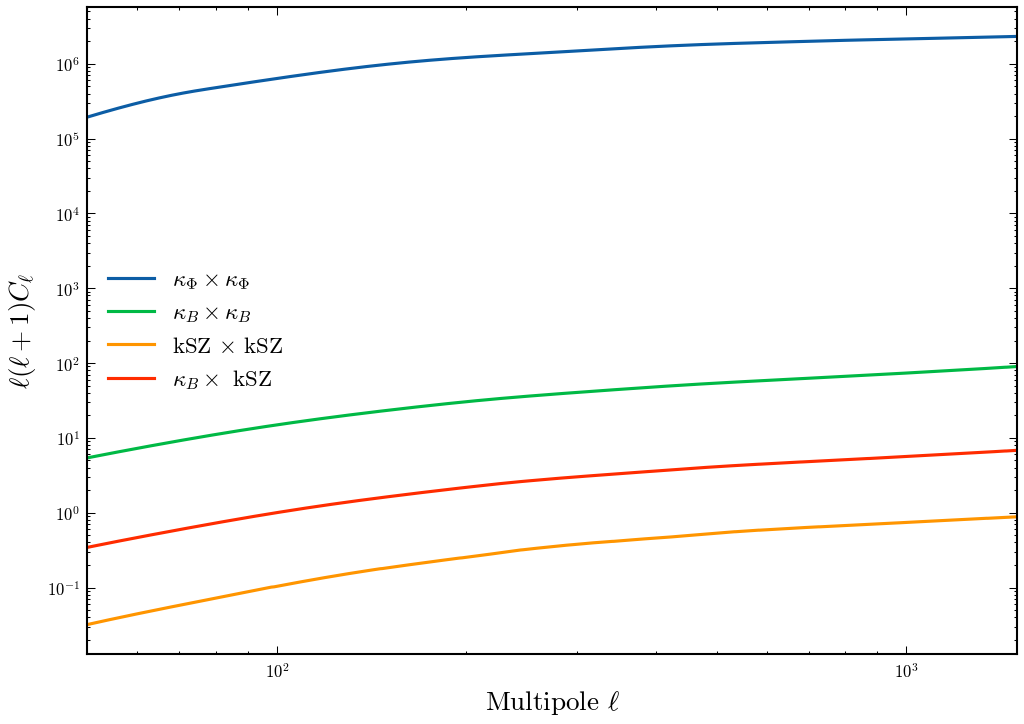

In [22]:
fig, ax = plt.subplots(figsize=(7, 5))

# Plot all spectra
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells['lensing']     , label=r"$\kappa_\Phi \times \kappa_\Phi$")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells['gravB']       , label=r"$\kappa_B \times \kappa_B$")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells['kSZ']         , label=r"kSZ $\times$ kSZ")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells['B_X_kSZ']     , label=r"$\kappa_B \times$ kSZ")

# Axis labels
ax.set_xlabel(r"Multipole $\ell$", fontsize=13)
ax.set_ylabel(r"$\ell(\ell+1)C_\ell$", fontsize=13)

# Legend
ax.legend(fontsize=11, loc="best", frameon=False)

# Grid and limits
# ax.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)
ax.set_xlim(ell_grid.min(), ell_grid.max())

plt.tight_layout()
plt.show()


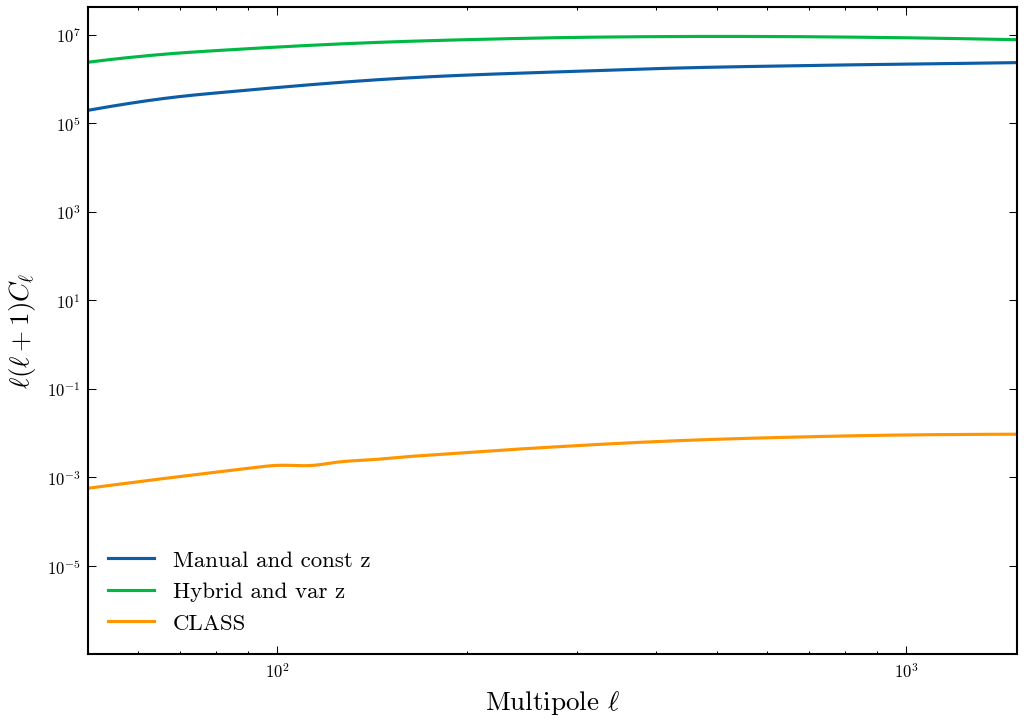

In [ ]:
cl['ell'], Cl_kk


fig, ax = plt.subplots(figsize=(7, 5))

factor = Cl_kk[ell_grid[-1]]/C_ells['lensing'][-1]

# Plot all spectra
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells['lensing'], label=r"Manual and const z")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells['lensing_class'], label=r"Hybrid and var z")
ax.loglog(cl['ell'], cl['ell']*(cl['ell']+1)*Cl_kk, label=r"CLASS")

# Axis labels
ax.set_xlabel(r"Multipole $\ell$", fontsize=13)
ax.set_ylabel(r"$\ell(\ell+1)C_\ell$", fontsize=13)

# Legend
ax.legend(fontsize=11, loc="best", frameon=False)

# Grid and limits
# ax.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)
ax.set_xlim(ell_grid.min(), ell_grid.max())

plt.tight_layout()
plt.show()


In [38]:
factor

4.2131208681919804e-09

### Old Attempts

In [ ]:
def C_ell_XY(chi_s, ell, kmin, kmax, Pk, kernelX, kernelY, z_min=1e-5, Pk_evol=False):
    """
    Compute C_ell^{XY} for two arbitrary kernels X and Y.
    
    Parameters
    ----------
    chi_s : float
        Source comoving distance.
    ell : float
        Multipole moment.
    kmin, kmax : float
        Limits of k to restrict the chi integration range.
    Pk : function
        Power spectrum P(k) or P(k,z) depending on Pk_evol.
    kernelX, kernelY : function
        Kernel functions of the form kernel(chi, chi_s) or kernel(chi).
    chi_min : float
        Minimum chi integration limit.
    Pk_evol : bool
        If True, Pk takes two arguments: Pk(k,z).
    """
    z_s = z_of_chi(chi_s)
    z_grid = np.linspace(z_min, z_s, 1000)
    chi_grid = chi_of_z(z_grid)  # need chi(z) relation

    # restrict to valid chi by k range
    mask = (ell/chi_grid < kmax) & (ell/chi_grid > kmin)
    z_masked = z_grid[mask]
    r = chi_grid[mask]
    
    if Pk_evol:
        C_ell_int = Pk(ell/r, z_masked) / r**2
    else:
        C_ell_int = Pk(ell/r) / r**2
    
    # multiply by kernels (handle signature difference)
    try:
        KX = kernelX(r, chi_s)
    except TypeError:
        KX = kernelX(r)
    try:
        KY = kernelY(r, chi_s)
    except TypeError:
        KY = kernelY(r)

    C_ell_int *= KX * KY
    
    # geometric prefactor you had
    C_ell_int *= sol / Hubble(z_masked)
    
    # integrate
    C_ell = simpson(C_ell_int, x=z_masked)
    
    return C_ell

In [ ]:
Pk_matter_int = interp1d(k_m, Pk_m, kind='quadratic')
Pk_matter_class_int = interp1d(k_vals, Pk_m_class, kind='quadratic')

Pk_omega_int = interp1d(k_q, Pk_omega, kind='quadratic')

Text(0, 0.5, '$P_\\text{q\\perp}(k)$')

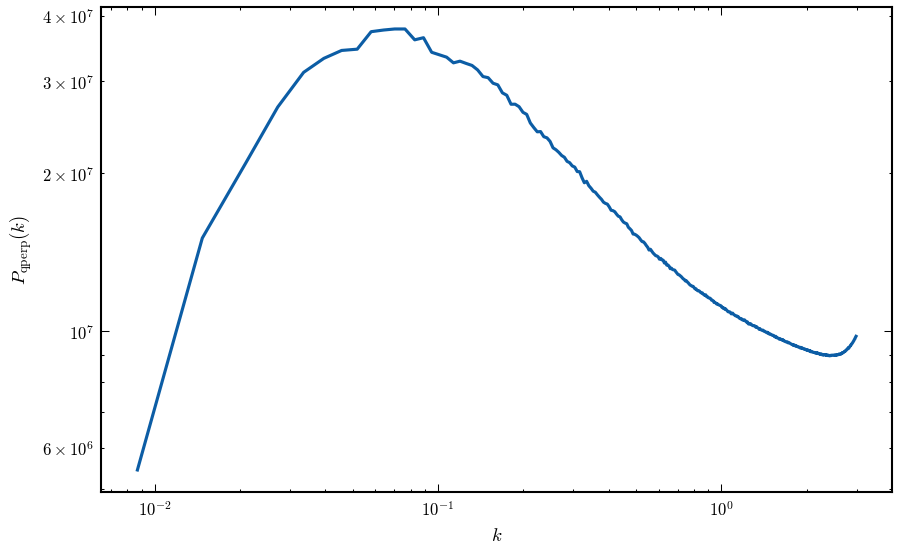

In [ ]:
idx_k = 400

fig, ax = plt.subplots()

ax.loglog(k_q[:-idx_k], Pk_omega_int(k_q[:-idx_k])/(k_q[:-idx_k]))
ax.set_xlabel('$k$')
ax.set_ylabel(r'$P_\text{q\perp}(k)$')

In [ ]:
ell_grid = np.arange(100,1001)

C_ells_ = np.zeros_like(ell_grid)

for idx, ell in enumerate(ell_grid):
    C_ells_WL[idx] = C_ell_XY(chi_of_z(3), ell, k_q[0], k_q[-1], Pk_omega_int, kernel_kappaB, kernel_kappaB)

In [ ]:
ell_grid = np.arange(100,10001)

C_ells = np.zeros_like(ell_grid)

for idx, ell in enumerate(ell_grid):
    C_ells[idx] = C_ell_ksz_kappaB(chi_of_z(3), ell, k_q[0], k_q[-401], Pk_omega_int)

In [ ]:
ell_grid = np.arange(100,1001)

C_ells_WL = np.zeros_like(ell_grid)

for idx, ell in enumerate(ell_grid):
    C_ells_WL[idx] = C_ell_WL(chi_of_z(3), ell, k_vals[0], k_vals[-1], Pk_matter_class_int)

NameError: name 'C_ell_WL' is not defined

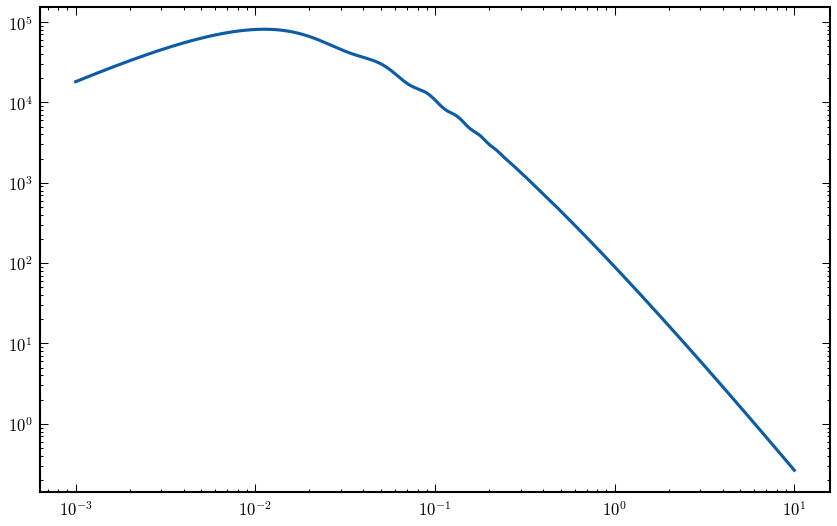

In [ ]:
fig, ax =plt.subplots()

ax.loglog(k_vals, Pk_matter_class_int(k_vals))

In [ ]:
k_vals[0], k_vals[-1]

(0.001, 10.0)

Text(0, 0.5, '$C_\\ell^{\\kappa_B kSZ}$')

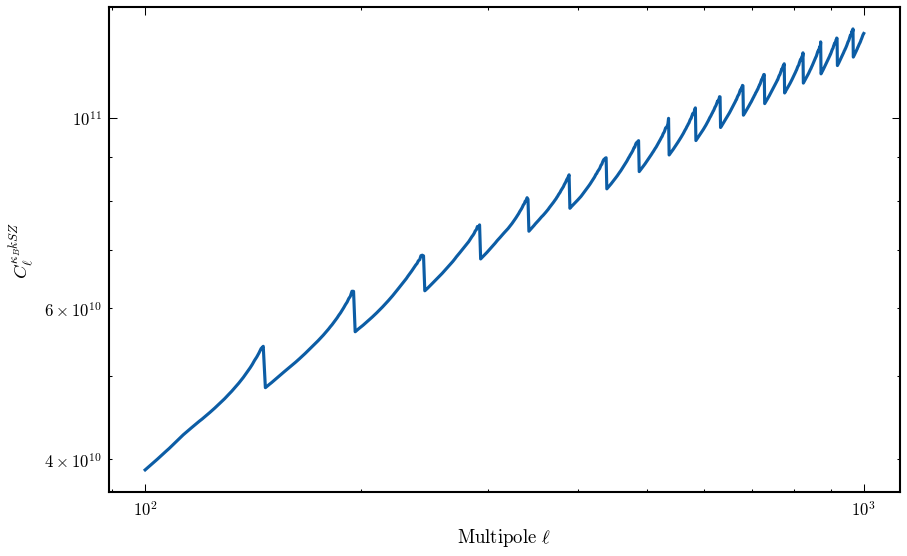

In [ ]:
idxfig, ax = plt.subplots()

ax.loglog(ell_grid, C_ells_WL)
ax.set_xlabel('Multipole $\ell$')
ax.set_ylabel('$C_\ell^{\kappa_B kSZ}$')

Text(0, 0.5, '$C_\\ell^{\\kappa_B kSZ}$')

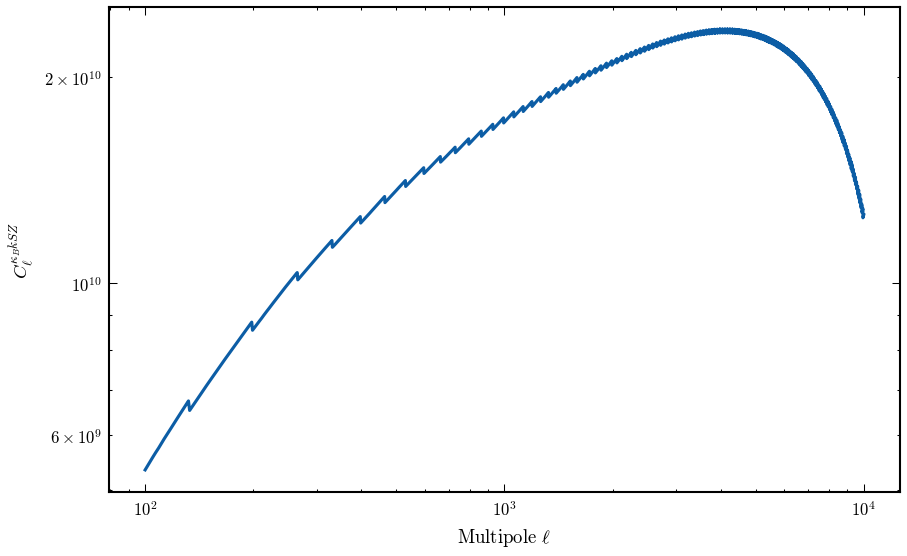

In [ ]:
fig, ax = plt.subplots()

ax.loglog(ell_grid, ell_grid*(1+ell_grid)*C_ells)
ax.set_xlabel('Multipole $\ell$')
ax.set_ylabel('$C_\ell^{\kappa_B kSZ}$')

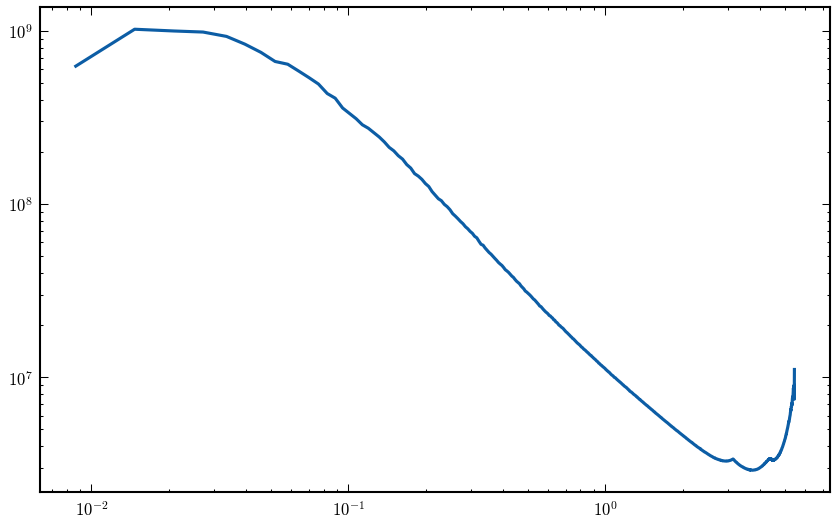

In [ ]:
plt.loglog(k_q, Pk_omega_int(k_q)/(k_q**2))

In [ ]:
C_ell, chis = C_ell_ksz_kappaB(3, 10, k_q[0], k_q[-401], Pk_omega_int)

IndexError: index 1 is out of bounds for axis 0 with size 0

In [ ]:
ell_grid = np.arange(100,1001)

C_ells = np.zeros_like(ell_grid)

for idx, ell in enumerate(ell_grid):
    C_ells[idx] = C_ell_ksz_kappaB(chi_of_z(3), ell, k_q[0], k_q[-1], Pk_omega_int)[0]

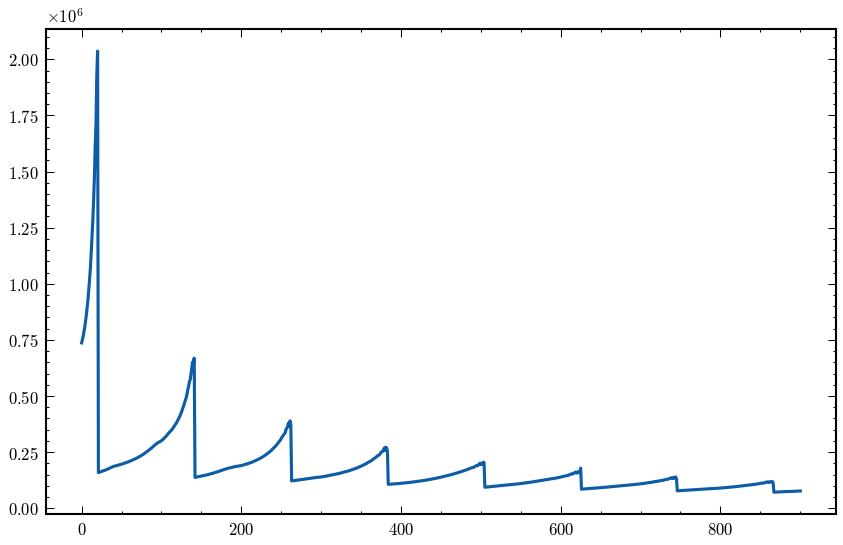

In [ ]:
plt.plot(C_ells)

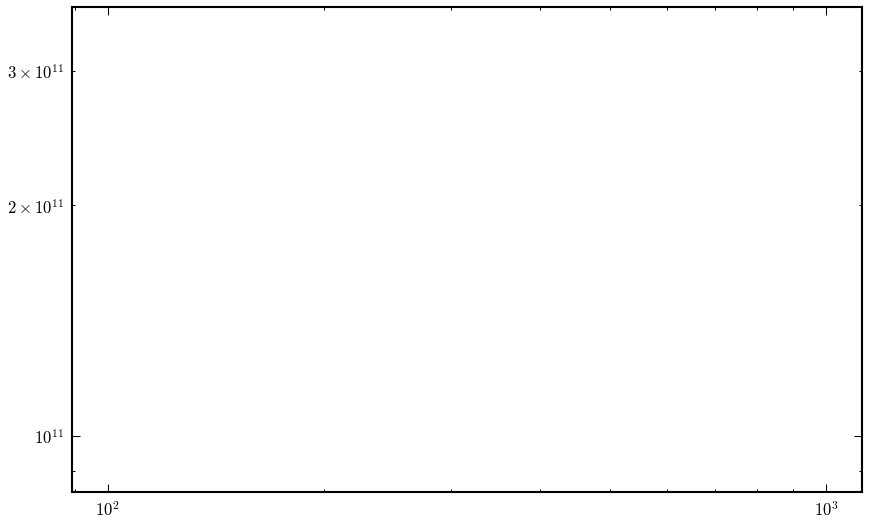

In [ ]:
ell_grid = np.arange(100,1001)

fig, ax = plt.subplots()

for idx, ell in enumerate(ell_grid):
    ax.loglog(ell, ell*(1+ell)*C_ell_ksz_kappaB(chi_of_z(3), ell, k_q[0], k_q[-1], Pk_omega_int))

---
CHATGPT
---


In [18]:
z_table = np.linspace(0, 3, 2000)
chi_table = np.zeros_like(z_table)

pars = parameters_sim
for i, zz in enumerate(z_table):
    z_grid = np.linspace(0, zz, 1000)
    integrand = 1 / Hubble(z_grid, pars=parameters_sim)
    chi_table[i] = simpson(integrand, x=z_grid) * pars['c'] * pars['h']

chi_interp = interp1d(z_table, chi_table, kind="cubic", fill_value="extrapolate")

def chi_of_z(z):
    return chi_interp(z)

In [19]:
def kernel_kappaB(z, z_s):
    """ Lensing convergence kernel for sources at z_s. """
    chi = chi_of_z(z)
    chi_s = chi_of_z(z_s)
    prefactor = 1.5 * pars['H0']**2 * pars['Omega_m'] / pars['c']**2
    output = prefactor * (1+z) * chi * (chi_s - chi) / chi_s
    return output * (z < z_s)  # enforce chi < chi_s


def kernel_ksz(z, z_s=None):
    """ kSZ kernel (independent of z_s). """
    a = a_of_z(z)
    chi = chi_of_z(z)
    output = (
        pars['SigmaT'] * 3.086e22 / pars['h'] *
        n_ele(z_of_a(a)) * a *
        np.exp(-tau_optical_depth(z))
    )
    return output


def kernel_kappaPhi(z, z_s):
    """ Phi-kappa cross kernel, proportional to kappaB. """
    return 0.5 * pars['c'] * kernel_kappaB(z, z_s)

In [20]:
def C_ell_XY(z_s, ell, kmin, kmax, Pk, kernelX, kernelY, z_min=1e-5, Pk_evol=False, pars=parameters_sim):
    """
    Compute C_ell^{XY} integrating over redshift.
    Kernels must have signature kernel(z, z_s).
    """
    z_grid = np.linspace(z_min, z_s, 1000)
    chi_grid = chi_of_z(z_grid)

    # restrict to valid chi by k-range
    mask = (ell/chi_grid < kmax) & (ell/chi_grid > kmin)
    z = z_grid[mask]
    chi = chi_grid[mask]
    if z.size == 0:  # safety check
        return 0.0

    if Pk_evol:
        C_ell_int = Pk(ell/chi, z) / chi**2
    else:
        C_ell_int = Pk(ell/chi) / chi**2
    
    # kernels
    KX = kernelX(z, z_s)
    KY = kernelY(z, z_s)
    C_ell_int *= KX * KY
    
    # factor dchi/dz
    C_ell_int *= pars['c'] / Hubble(z, pars)
    
    # integrate in z
    C_ell = simpson(C_ell_int, x=z)
    return C_ell

In [21]:
ell_grid = np.arange(100, 1001)
C_ells_gravB = np.zeros_like(ell_grid, dtype=float)
C_ells_lens = np.zeros_like(ell_grid, dtype=float)
C_ells_ksz = np.zeros_like(ell_grid, dtype=float)
C_ells_gravB_x_ksz = np.zeros_like(ell_grid, dtype=float)

for idx, ell in enumerate(ell_grid):
    C_ells_gravB[idx] = C_ell_XY(
        z_s=3.0,  # source redshift
        ell=ell,
        kmin=k_q[0],
        kmax=k_q[-1],
        Pk=Pk_omega_int,
        kernelX=kernel_kappaB,
        kernelY=kernel_kappaB
    )
    C_ells_lens[idx] = C_ell_XY(
        z_s=3.0,  # source redshift
        ell=ell,
        kmin=k_m[0],
        kmax=k_m[-1],
        Pk=Pk_matter_int,
        kernelX=kernel_kappaPhi,
        kernelY=kernel_kappaPhi
    )
    C_ells_ksz[idx] = C_ell_XY(
        z_s=3.0,  # source redshift
        ell=ell,
        kmin=k_q[0],
        kmax=k_q[-1],
        Pk=Pk_omega_int,
        kernelX=kernel_ksz,
        kernelY=kernel_ksz
    )
    C_ells_gravB_x_ksz[idx] = C_ell_XY(
        z_s=3.0,  # source redshift
        ell=ell,
        kmin=k_q[0],
        kmax=k_q[-1],
        Pk=Pk_omega_int,
        kernelX=kernel_kappaB,
        kernelY=kernel_ksz
    )

Text(0, 0.5, '$C_\\ell^{\\kappa_B kSZ}$')

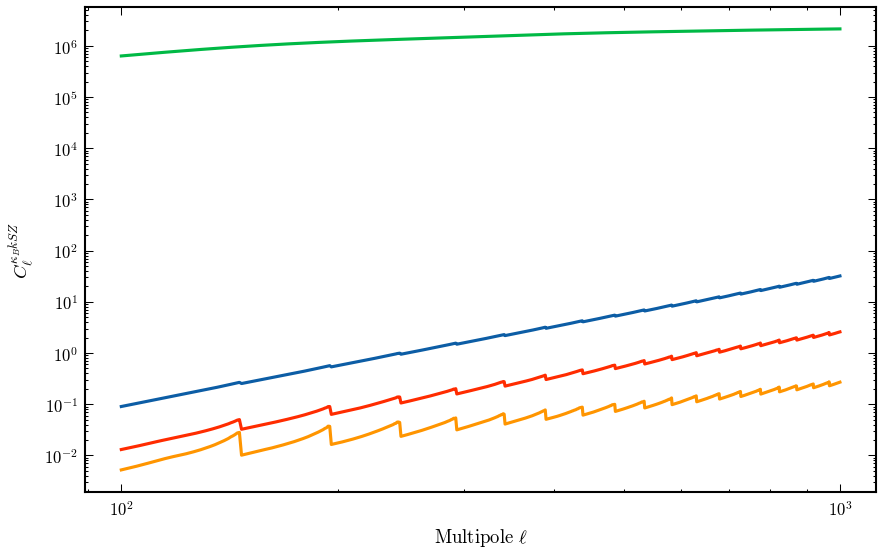

In [22]:
fig, ax = plt.subplots()

ax.loglog(ell_grid, ell_grid*(1+ell_grid)*C_ells_gravB)
ax.loglog(ell_grid, ell_grid*(1+ell_grid)*C_ells_lens)
ax.loglog(ell_grid, ell_grid*(1+ell_grid)*C_ells_ksz)
ax.loglog(ell_grid, ell_grid*(1+ell_grid)*C_ells_gravB_x_ksz)
ax.set_xlabel('Multipole $\ell$')
ax.set_ylabel('$C_\ell^{\kappa_B kSZ}$')

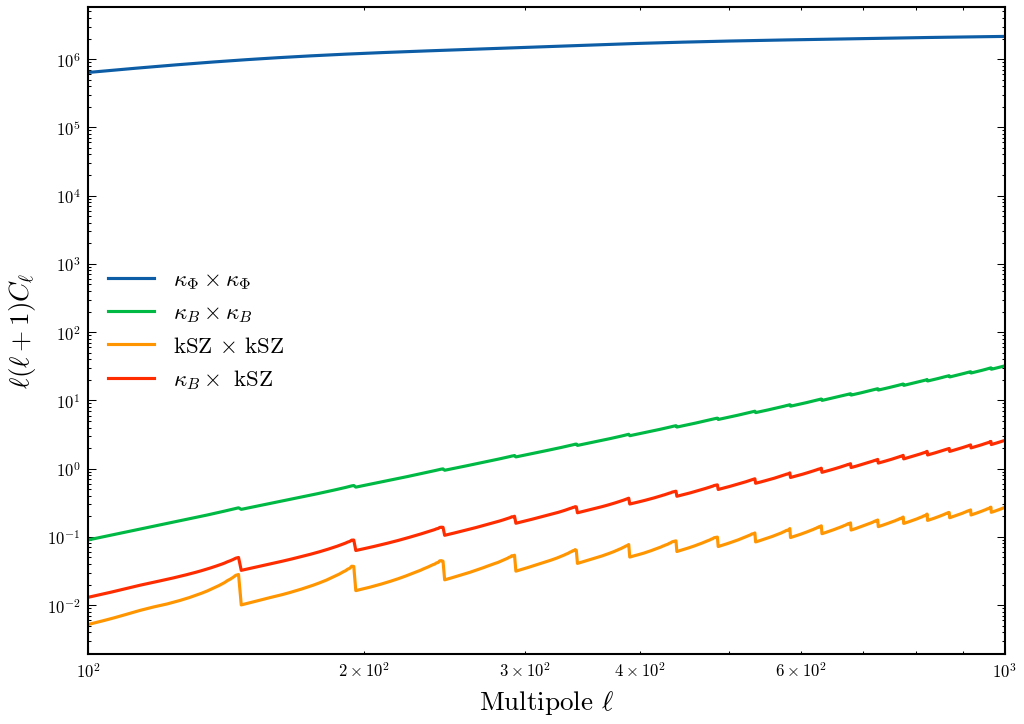

In [23]:
fig, ax = plt.subplots(figsize=(7, 5))

# Plot all spectra
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_lens, label=r"$\kappa_\Phi \times \kappa_\Phi$")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_gravB, label=r"$\kappa_B \times \kappa_B$")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_ksz, label=r"kSZ $\times$ kSZ")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_gravB_x_ksz, label=r"$\kappa_B \times$ kSZ")

# Axis labels
ax.set_xlabel(r"Multipole $\ell$", fontsize=13)
ax.set_ylabel(r"$\ell(\ell+1)C_\ell$", fontsize=13)

# Legend
ax.legend(fontsize=11, loc="best", frameon=False)

# Grid and limits
# ax.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)
ax.set_xlim(ell_grid.min(), ell_grid.max())

plt.tight_layout()
plt.show()
